In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("../data/cleaned/online_retail_cleaned.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12


In [2]:
# Find the first purchase month for each customer

first_purchase = (
    df.groupby('CustomerID')['InvoiceMonth']
    .min()
    .reset_index(name='CohortMonth')
)

# Add the CohortMonth back to the main dataframe
df=df.merge(first_purchase, on='CustomerID', how = 'left')

# Preview the updated dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,2010-12


In [3]:
# Compute the number of months between the customer's first purchase (CohortMonth)
# and the month of the current transaction (InvoiceMonth).
# This creates a normalized timeline for cohort analysis (Month 0, Month 1, Month 2, ...).

# Calculate how many months have passed since each customer's first purchase
df['CohortIndex'] = (
    (df['InvoiceMonth'].dt.year - df['CohortMonth'].dt.year) * 12 +
    (df['InvoiceMonth'].dt.month - df['CohortMonth'].dt.month)
)
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth,CohortIndex
397879,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12,2011-08,4
397880,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12,2011-08,4
397881,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12,2011-08,4
397882,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12,2011-08,4
397883,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,2011-12,2011-08,4


In [4]:
# Aggregate total revenue for each cohort at every stage of its lifecycle.
# - CohortMonth identifies when customers first entered the business.
# - CohortIndex represents how many months have passed since that first purchase.
# Summing revenue across these two dimensions allows to analyze revenue retention,
# customer value growth, and long‑term cohort performance in a structured way.

cohort_revenue = (
    df.groupby(['CohortMonth', 'CohortIndex'])['Revenue']
    .sum()
    .reset_index()
)


cohort_revenue

,CohortMonth,CohortIndex,Revenue
0,2010-12,0,572713.89
1,2010-12,1,276237.69
2,2010-12,2,233845.37
3,2010-12,3,303119.39
4,2010-12,4,204407.66
...,...,...,...
86,2011-10,1,40026.68
87,2011-10,2,12621.10
88,2011-11,0,136592.12
89,2011-11,1,15284.61


In [5]:
# Create a pivot table to visualize revenue retention across cohorts over time
cohort_revenue_pivot = cohort_revenue.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='Revenue'
)
cohort_revenue_pivot.round(2)

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,572713.89,276237.69,233845.37,303119.39,204407.66,336627.50,314162.61,310783.92,331749.22,472813.64,456080.61,513803.59,185803.13
2011-01,293207.35,55149.91,63268.17,71587.40,81114.09,84583.78,70107.40,72689.71,72023.65,111803.90,123882.10,26464.82,NaN
2011-02,158142.07,29043.24,41134.38,48238.86,40147.91,34223.23,49706.63,62450.83,55380.06,64809.45,10600.22,NaN,NaN
2011-03,200069.96,30059.43,59057.51,42816.61,51657.33,40020.81,64919.49,71023.95,71265.83,12868.02,NaN,NaN,NaN
2011-04,122011.49,29452.82,25077.07,24311.47,26314.19,30206.30,28668.98,34228.61,6350.10,NaN,NaN,NaN,NaN
2011-05,124103.78,18682.76,20193.76,19162.17,27861.87,32976.60,33312.91,179251.53,NaN,NaN,NaN,NaN,NaN
2011-06,135742.95,14805.15,14155.40,30961.59,26754.54,42808.25,8227.35,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,74008.75,11789.67,15534.18,17551.47,19512.11,6072.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,79756.10,20962.93,35503.90,44541.76,15284.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Cumulative Revenue Retention Table
cohort_cumulative_revenue = cohort_revenue_pivot.cumsum(axis=1)
cohort_cumulative_revenue.round(2)

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,572713.89,848951.58,1082796.95,1385916.34,1590324.00,1926951.50,2241114.11,2551898.03,2883647.25,3356460.89,3812541.50,4326345.09,4512148.22
2011-01,293207.35,348357.26,411625.43,483212.83,564326.92,648910.70,719018.10,791707.81,863731.46,975535.36,1099417.46,1125882.28,NaN
2011-02,158142.07,187185.31,228319.69,276558.55,316706.46,350929.69,400636.32,463087.15,518467.21,583276.66,593876.88,NaN,NaN
2011-03,200069.96,230129.39,289186.90,332003.51,383660.84,423681.65,488601.14,559625.09,630890.92,643758.94,NaN,NaN,NaN
2011-04,122011.49,151464.31,176541.38,200852.85,227167.04,257373.34,286042.32,320270.93,326621.03,NaN,NaN,NaN,NaN
2011-05,124103.78,142786.54,162980.30,182142.47,210004.34,242980.94,276293.85,455545.38,NaN,NaN,NaN,NaN,NaN
2011-06,135742.95,150548.10,164703.50,195665.09,222419.63,265227.88,273455.23,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,74008.75,85798.42,101332.60,118884.07,138396.18,144468.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,79756.10,100719.03,136222.93,180764.69,196049.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# cohort_size counts how many unique customers belong to each cohort.
cohort_size = (
    df.groupby('CohortMonth')['CustomerID']
    .nunique()
)

cohort_size

CohortMonth
2010-12    885
2011-01    417
2011-02    380
2011-03    452
2011-04    300
2011-05    284
2011-06    242
2011-07    188
2011-08    169
2011-09    299
2011-10    358
2011-11    323
2011-12     41
Freq: M, Name: CustomerID, dtype: int64

In [8]:
#Normalized Revenue Retention Table
cohort_size = (
    df.groupby('CohortMonth')['CustomerID']
    .nunique()
)

# Calculate revenue per customer for each cohort over time
revenue_per_customer = cohort_cumulative_revenue.divide(
    cohort_size, axis=0
)

# Display the normalized average revenue each customer has generated over time
revenue_per_customer.round(2)


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,647.13,959.27,1223.50,1566.01,1796.98,2177.35,2532.33,2883.50,3258.36,3792.61,4307.96,4888.53,5098.47
2011-01,703.14,835.39,987.11,1158.78,1353.30,1556.14,1724.26,1898.58,2071.30,2339.41,2636.49,2699.96,NaN
2011-02,416.16,492.59,600.84,727.79,833.44,923.50,1054.31,1218.65,1364.39,1534.94,1562.83,NaN,NaN
2011-03,442.63,509.14,639.79,734.52,848.81,937.35,1080.98,1238.11,1395.78,1424.25,NaN,NaN,NaN
2011-04,406.70,504.88,588.47,669.51,757.22,857.91,953.47,1067.57,1088.74,NaN,NaN,NaN,NaN
2011-05,436.99,502.77,573.87,641.35,739.45,855.57,972.87,1604.03,NaN,NaN,NaN,NaN,NaN
2011-06,560.92,622.10,680.59,808.53,919.09,1095.98,1129.98,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,393.66,456.37,539.00,632.36,736.15,768.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,471.93,595.97,806.05,1069.61,1160.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Revenue & Customer Value Insights
- Some cohorts demonstrate strong revenue growth over time, indicating effective retention and upselling strategies.
- Cohorts with better initial revenue tend to maintain higher revenue levels in subsequent months.
- 2010-12 cohort shows significant revenue growth, suggesting successful engagement strategies. 
- Theres a general trend of increasing revenue per customer over time across cohorts, indicating improved customer value. 
-Across cohorts, revenue per customer generally increases over time despite declining cohort sizes. This suggests that customers who remain active tend to become more valuable, highlighting the importance of early retention and long-term customer engagement.



# Buissness Implications
- Acquisition channels that bring in high-value customers should be prioritized.
- Customer lifetime value varies significantly across cohorts, indicating changing - Customer behavior or market conditions suggesting the need for adaptive marketing and retention strategies.
- Rentation efforts should focus on the first few months after acquisition, where every customer you retain has a significant impact on revenue growth in later months.

In [16]:
# Group the dataset by CohortMonth and CohortIndex
# CohortMonth = the month the customer first appeared
# CohortIndex = how many months since the cohort started (0 = acquisition month)

cohort_data = (
    df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID']
    .nunique()
    .reset_index()
)

# Pivot the cohort data into a matrix:
# - Rows = CohortMonth (when each customer cohort started)
# - Columns = CohortIndex (months since the cohort's first activity)
# - Values = number of unique customers active in each period
cohort_pivot = cohort_data.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='CustomerID'
)

# Calculate the size of each cohort (number of unique customers at CohortIndex 0)
cohort_size_0 = cohort_pivot.iloc[:, 0]

# Calculate retention rates:
# Divide each row by its cohort size to get the percentage of customers retained
# in each subsequent month
retention = cohort_pivot.divide(cohort_size_0, axis=0)
retention.round(2) *100

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,100.0,37.0,32.0,38.0,36.0,40.0,36.0,35.0,35.0,40.0,37.0,50.0,27.0
2011-01,100.0,22.0,27.0,23.0,32.0,29.0,25.0,24.0,30.0,33.0,36.0,12.0,NaN
2011-02,100.0,19.0,19.0,28.0,27.0,25.0,25.0,28.0,25.0,31.0,7.0,NaN,NaN
2011-03,100.0,15.0,25.0,20.0,22.0,17.0,27.0,23.0,28.0,9.0,NaN,NaN,NaN
2011-04,100.0,21.0,20.0,21.0,20.0,23.0,22.0,26.0,7.0,NaN,NaN,NaN,NaN
2011-05,100.0,19.0,17.0,17.0,21.0,23.0,26.0,10.0,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,17.0,16.0,26.0,23.0,33.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,18.0,21.0,22.0,27.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,21.0,25.0,24.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


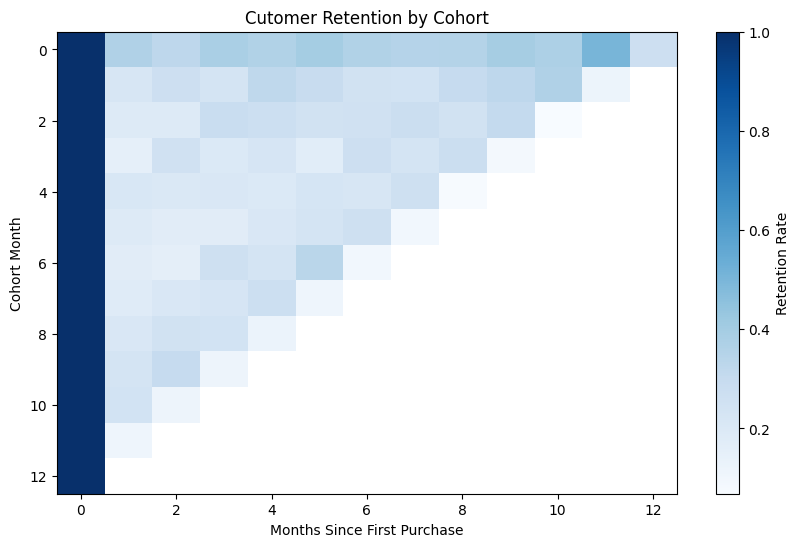

In [25]:
#Plotting the Retention Heatmap Customer Behaviour

# Visualize customer retention using a heatmap.
# - Each row represents a cohort (CohortMonth)
# - Each column represents months since the customer's first purchase (CohortIndex)
# - Color intensity reflects the retention rate for that cohort at each lifecycle month
# This heatmap makes it easy to identify retention patterns, drop-off points,
# and differences in behavior across customer cohorts.

plt.figure(figsize=(10, 6))
plt.imshow(retention, aspect='auto', cmap='Blues')
plt.colorbar(label='Retention Rate')
plt.title('Cutomer Retention by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.show()

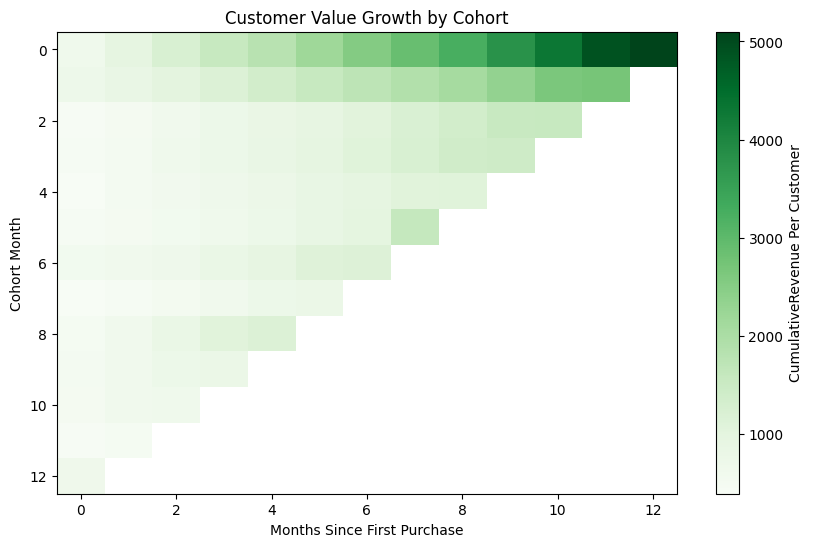

In [23]:
# Plot Revenue per Customer Heatmap (VALUE BEHAVIOUR)

# - Each row represents a cohort (based on the customer's first purchase month)
# - Each column represents the number of months since that first purchase
# - The color intensity shows how customer value grows over time
# This chart helps identify patterns in customer lifetime value (LTV) across cohorts.

plt.figure(figsize=(10, 6))
plt.imshow(revenue_per_customer, aspect='auto', cmap='Greens')
plt.colorbar(label='CumulativeRevenue Per Customer')
plt.title('Customer Value Growth by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.show()

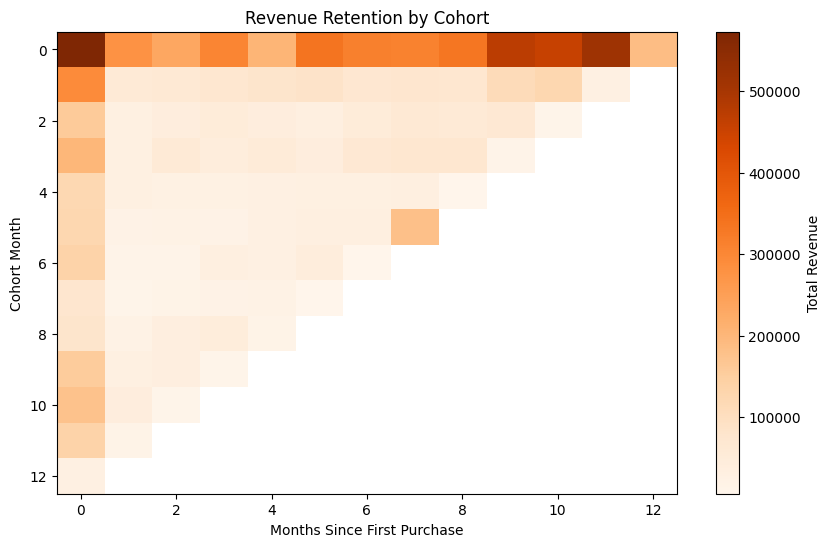

In [24]:
# Revenue retention across cohorts over time
plt.figure(figsize=(10, 6))
plt.imshow(cohort_revenue_pivot, aspect='auto', cmap='Oranges')
plt.colorbar(label='Total Revenue')
plt.title('Revenue Retention by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.show()

# Executive Interpretation
- Retention drops sharply after the first month, indicating that many customers do not return after their initial purchase. indicating weak early engagement.
- Those who do return tend to generate increasing revenue over time, suggesting that loyal customers contribute significantly to long-term revenue growth. 
- High value cohorts should be protected through targeted retention strategies to maximize their lifetime value.
- Early retention is critical, efforts to improve engagement in the first few months could yield substantial long-term revenue benefits.

## Recommendations Actions
- Enhance and inest in onboarding Experience, since retention drops significantly after the first month, focus on improving the onboarding process to engage new customers better.
- Identify behaviors in the first month that correlate with long-term value, and replicate successful strategies across other customer segments.
- Evaluate acquisition channels based on cohort value performance to optimize marketing spend and attract high-value customers.
- Place priority on retaining high-value cohorts through targeted marketing and personalized offers, as they contribute significantly to overall revenue.